## Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

### Part 1 - Response
The first thing to do is import the data and check for anomolies. We'll check by plotting a histogram of the number of days between the first date and the current date. After this, we'll resample the data to 15-minute intervals and plot the data at a number of seasonalities.

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

# import data
logins = pd.read_json('logins.json')
logins.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

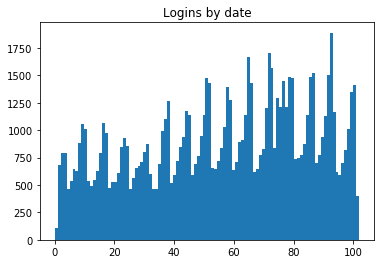

In [149]:
# plot difference between current date and Jan 1, 1970
_ = plt.hist(logins.login_time.apply(lambda x: (x.normalize() - pd.Timestamp('1970-01-01')).days), bins = 103)
_ = plt.title('Logins by date')
_ = plt.show()

In [150]:
# resample by 15-min intervals
logins['count'] = 1
logins = logins.set_index('login_time').resample('15T').sum()
logins.head()

count
login_time                
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1

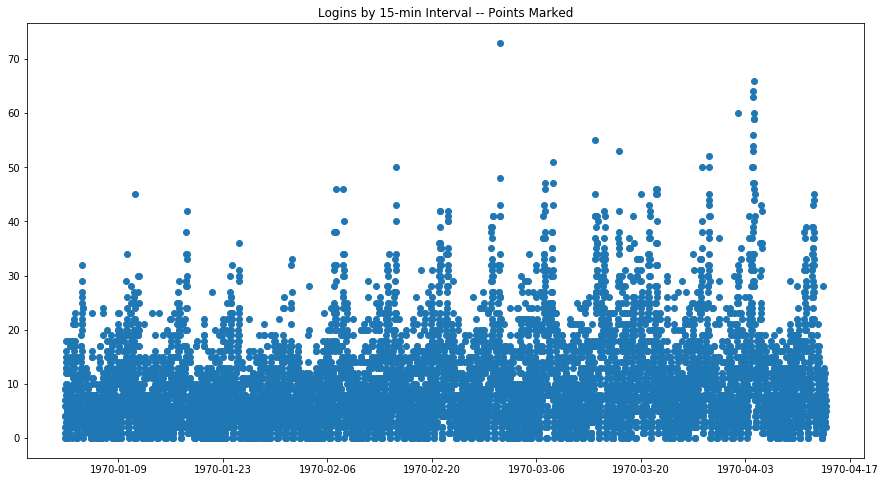

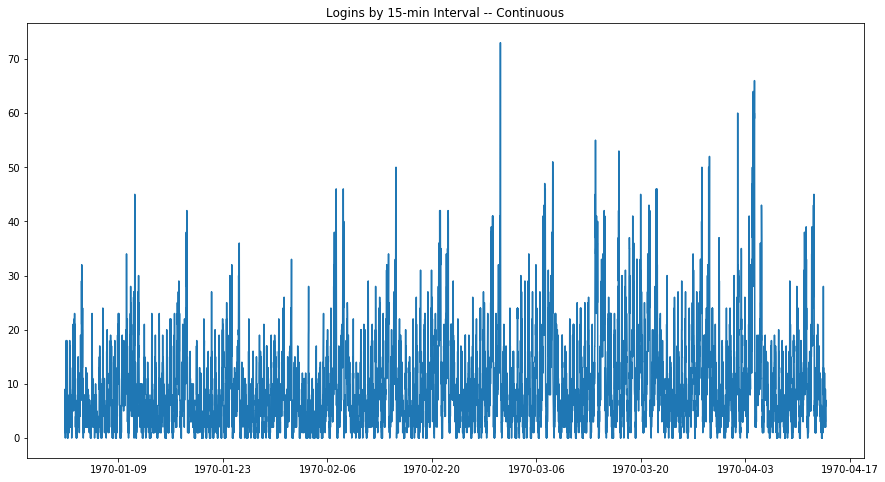

In [152]:
# visualize count by time
_ = plt.figure(figsize=(15,8))
_ = plt.plot(logins, marker='o', linestyle='None')
_ = plt.title('Logins by 15-min Interval -- Points Marked')
_ = plt.show()

_ = plt.figure(figsize=(15,8))
_ = plt.plot(logins)
_ = plt.title('Logins by 15-min Interval -- Continuous')
_ = plt.show()

The resampled 15-minute plots show that there is a regular ebb and flow in the data. There appears to be one 15-minute interval with 73 logins, which could be bad data, but without more information it is difficult to tell. There does not appear to be any upward or downward trend in the data.

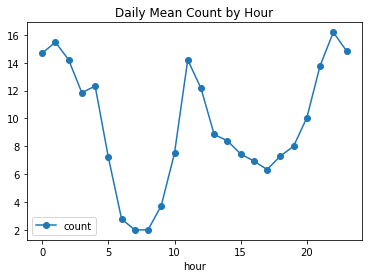

In [199]:
logins['hour'] = logins.index
logins['hour'] = logins.hour.apply(lambda x: x.hour)
_ = logins.loc[:, ['count', 'hour']].groupby('hour').mean().plot(marker='o')
_ = plt.title("Daily Mean Count by Hour")
_ = plt.show()

The hourly means show that logins peaked around midnight and then again around noon. The daily lull came around 7am and then (less so) at 5pm.

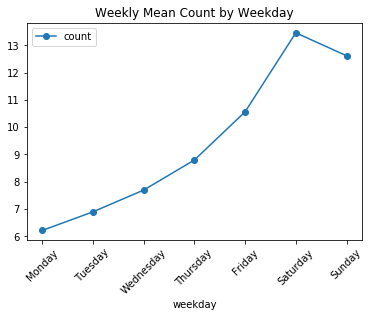

In [198]:
logins['weekday'] = logins.index
logins['weekday'] = logins.weekday.apply(lambda x: x.weekday())
_ = logins.loc[:, ['count', 'weekday']].groupby('weekday').mean().plot(marker='o')
_ = plt.title("Weekly Mean Count by Weekday")
_ = plt.xticks(range(0,7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
_ = plt.show()

There is a steady increase in logins as the workweek progresses. Logins peak on Saturdays, declining slightly on Sundays.

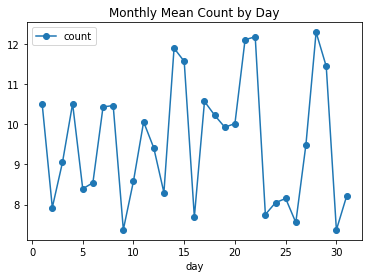

In [200]:
logins['day'] = logins.index
logins['day'] = logins.day.apply(lambda x: x.day)
_ = logins.loc[:, ['count', 'day']].groupby('day').mean().plot(marker='o')
_ = plt.title("Monthly Mean Count by Day")
_ = plt.show()

There does not appear to be any monthly pattern, which makes sense given the weekly pattern and the mismatch in days in each month. This is important, however, because it does not appear that (given the limited data) users log in necessarily more/less at the beginning or end of the month.

## Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
<ul><li>a. how you will implement the experiment
<li>b. what statistical test(s) you will conduct to verify the significance of the
observation
<li>c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### Part 2 - Response

1. The goal is not necessarily to see if inter-city trips increases (which would look at an estimation of daily previous bridge-crossings compared to reimbursed tolls), but to increase driver availability in both cities. Because of this, I would look at average _weekend_ wait times before and after tolls are reimbursed, assuming greater driver ability would decrease rider wait times.
2. I'm going to assume the drivers all work for the same company and that historical data is availble, which shows not only the wait and drive times of each trip, but the pickup and dropoff locations. Depending on the needs or demands of the city managers, the experiment could look back a month or a year to assess change. Ideally, the data from one year back would be compared to the data one year after the change, comparing daily rider wait times. I think a year would be needed to attempt to account for seasonal differences and possible weather differences. In this case, the data would be ${W}_{ij}$ where each weekend is the mean wait time for weekend $i = 1, ..., 52$ for each year $j = 1, 2$. The test would be a paired t-test at $\alpha = 0.05$ testing the hypotheses ${H}_0: {\mu}_.1 \ge {\mu}_.2$ and ${H}_A: {\mu}_.1 < {\mu}_.2$, where ${\mu}_.j$ is $\frac{1}{52}\sum_{i=1}^{52}{W}_{ij}$ for each year. If the null hypothesis is rejected, I would say that according to this single key measure of success, the city managers' plan succeeded. I would want to look at more than a single test, and no matter the outcome, I would look at rider trends in the cities separately to see if the number of drivers, riders, and locations stayed the same and if the peak hours and prices differed much. It could be, also, that ridership quality increases in one city and decreases in another, so more tests would likely need to be done.

## Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.  

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

### Part 3 - Response
For this section, we need to begin by loading in the data and cleaning it up. We can then perform logistic regression and interpret the results.

In [201]:
import json

# import data
with open('ultimate_data_challenge.json', 'r') as file:
    ultimate = pd.DataFrame(json.load(file))

# fix datetimes and add 'active' column
ultimate['last_trip_date'] = pd.to_datetime(ultimate['last_trip_date'])
ultimate['signup_date'] = (pd.Timestamp('2014-07-01') - pd.to_datetime(ultimate['signup_date'])).apply(lambda x: x.days) # make 'days since signup'
ultimate['active'] = (pd.Timestamp('2014-07-01') - ultimate.last_trip_date) < pd.Timedelta('30 days')
ultimate.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone  signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone          157       15.4   
1         Astapor     2014-05-05  Android          153        0.0   
2         Astapor     2014-01-07   iPhone          176        0.0   
3  King's Landing     2014-06-29   iPhone          172       20.0   
4      Winterfell     2014-03-15  Android          155       11.8   

   trips_in_first_30_days  ultimate_black_user  weekday_pct  active  
0                       4                 True         46.2    True  
1                       0                False         50.0   False  
2                       3                False        100.0   False  
3                       9                 True         80.0    True  
4                      14                False         82.4   False

In [202]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(6), int64(2), object(2)
memory usage: 4.3+ MB


In [48]:
ultimate.describe()

avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
std        5.707357              0.446652              0.617338      0.222336   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   

       signup_date     surge_pct  trips_in_first_30_days   weekday_pct  
count  50000.00000  50000.000000            50000.000000  50000.000000  
mean     165.45532      8.849536                2.278200     60.926084  
std        8.75422     19.958811                3.792684     37.081503  
min      151.00000      0.000000                0.000000      0.000000  
25%      158.00000      0.000000                0.000000     33.300000  
50%      165.00000      0.000000                1.000000     66.700000  
75%      173.00000      8.600000                3.000000    100.000000  
max      181.00000    100.000000              125.000000    100.000000

An initial glance at this data shows that at least 15% of the data is missing. Because imputing data for these columns could skew the results, imputing data without a solid understanding of the interplay between variables seems like a misstep.

In [219]:
ultimate = ultimate.dropna()
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 13 columns):
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
city                      41445 non-null object
last_trip_date            41445 non-null datetime64[ns]
phone                     41445 non-null object
signup_date               41445 non-null int64
surge_pct                 41445 non-null float64
trips_in_first_30_days    41445 non-null int64
ultimate_black_user       41445 non-null bool
weekday_pct               41445 non-null float64
active                    41445 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(6), int64(2), object(2)
memory usage: 3.9+ MB


In [220]:
ultimate.describe()

avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  41445.000000          41445.000000          41445.000000  41445.000000   
mean       5.460046              4.776446              4.601720      1.073822   
std        5.145174              0.404606              0.616104      0.198747   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.780000              5.000000              4.900000      1.000000   
75%        6.490000              5.000000              5.000000      1.070000   
max       79.690000              5.000000              5.000000      8.000000   

        signup_date     surge_pct  trips_in_first_30_days   weekday_pct  
count  41445.000000  41445.000000            41445.000000  41445.000000  
mean     165.532248      8.898709                2.609675     61.254897  
std        8.738060     18.322061                4.059336     34.813848  
min      151.000000      0.000000                0.000000      0.000000  
25%      158.000000      0.000000                0.000000     37.500000  
50%      165.000000      0.000000                1.000000     66.700000  
75%      173.000000     11.100000                3.000000    100.000000  
max      181.000000    100.000000              125.000000    100.000000

At this point, nearly 20% of the data is missing. This is unfortunate, but without more domain knowledge, it does not seem wise to impute any data.

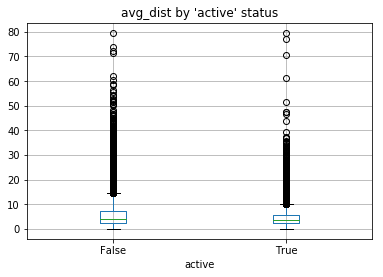

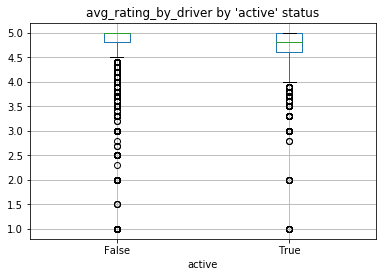

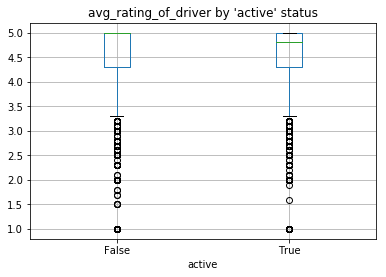

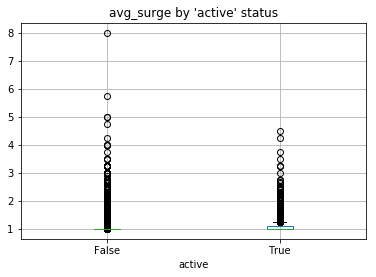

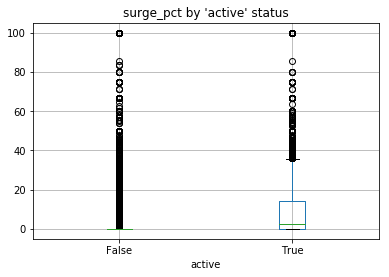

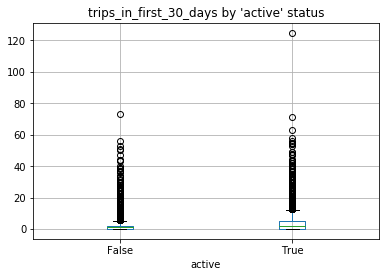

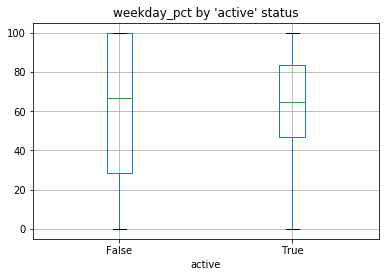

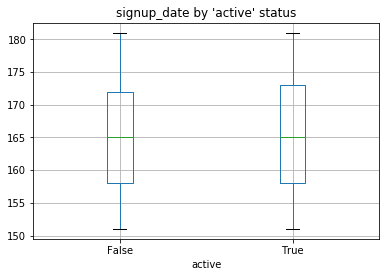

In [222]:
boxplot_cols = ['avg_dist',
 'avg_rating_by_driver',
 'avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'trips_in_first_30_days',
 'weekday_pct',
 'signup_date']

for i in boxplot_cols:
    _ = ultimate.boxplot(column=i, by='active')
    _ = plt.title(i + " by 'active' status")
    _ = plt.suptitle("")
    _ = plt.show()

The boxplots show that Active and Inactive users distributions look similar except for surge_pct and the number of trips in the first 30 days. In both cases, Active users tended to have higher values.

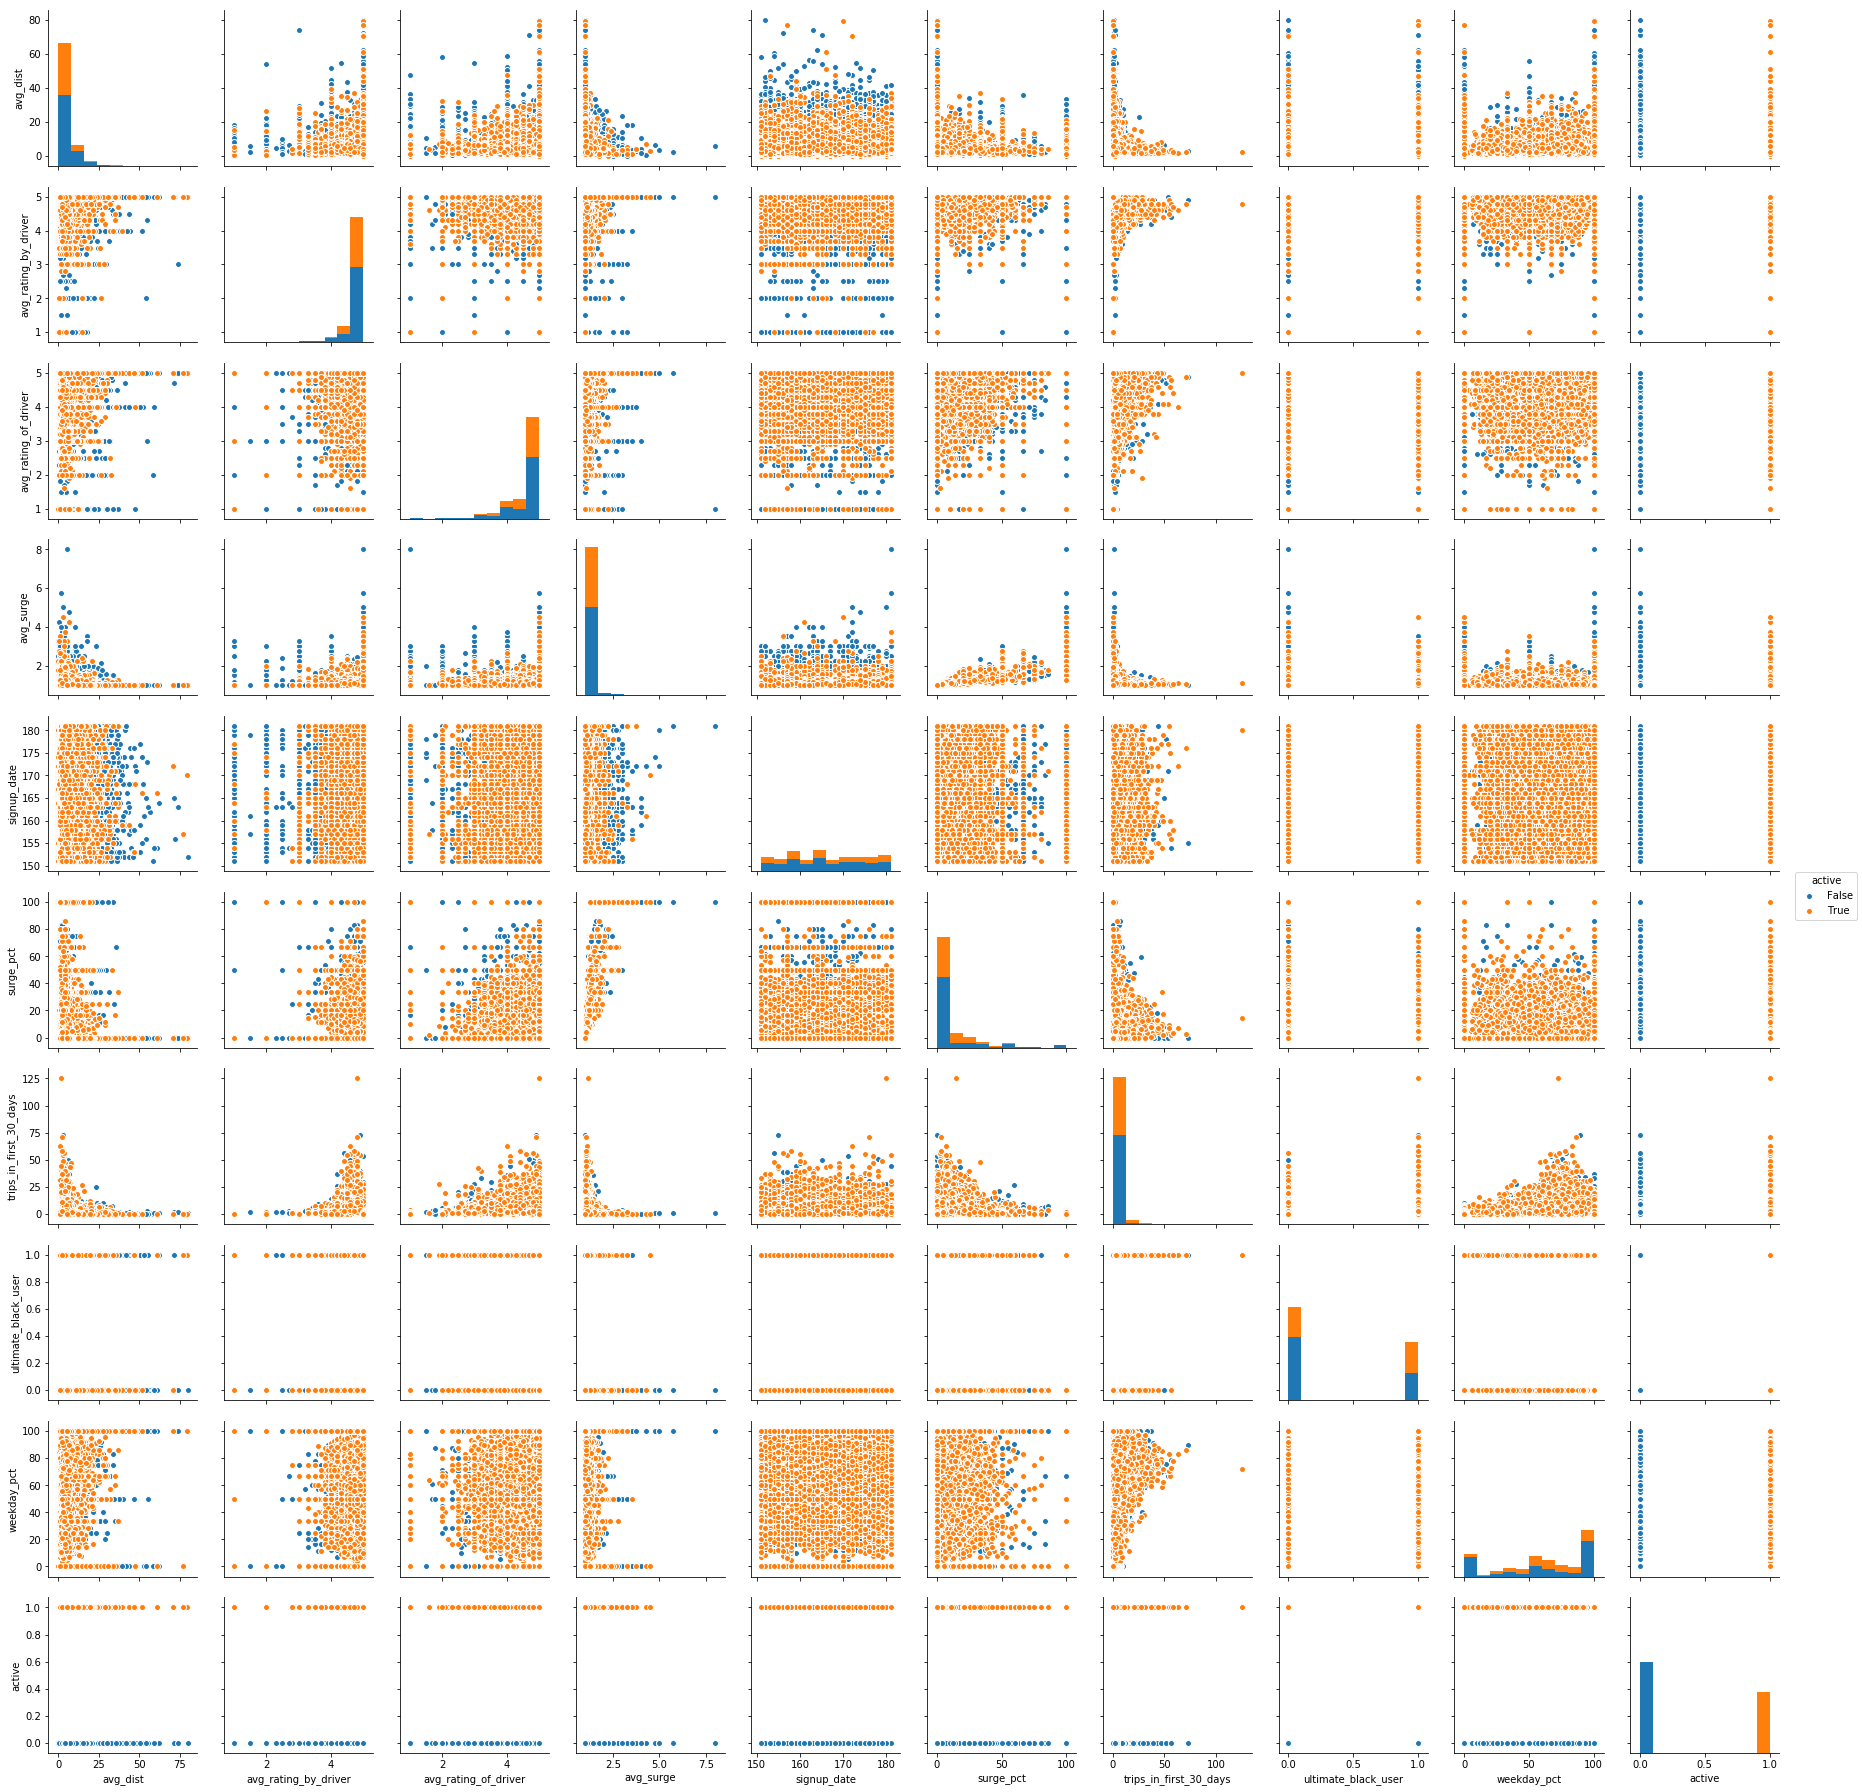

In [225]:
import seaborn as sns
_ = sns.pairplot(ultimate, hue='active')
_ = plt.show()

This pairplot shows that none of the predictors are plagued by collinearity and that the dispersion of Active and Inactive users is fairly similar in all cases.

In [259]:
pd.crosstab(ultimate.ultimate_black_user, ultimate.active, margins=True)

active               False   True    All
ultimate_black_user                     
False                17492   8034  25526
True                  7345   8574  15919
All                  24837  16608  41445

In [258]:
pd.crosstab(ultimate.city, ultimate.active, margins=True)

active          False   True    All
city                               
Astapor          9865   3644  13509
King's Landing   3088   5687   8775
Winterfell      11884   7277  19161
All             24837  16608  41445

In [292]:
pd.crosstab(ultimate.phone, ultimate.active, margins=True)

active   False   True    All
phone                       
Android   9460   2633  12093
iPhone   15377  13975  29352
All      24837  16608  41445

The crosstabs above show that :
1. About half of active users are Ultimate Black users, while only 30% of Inactive users were. 
2. City is highly indicative of Active status, as King's Landing has more Active than Inactive users, while Astapor and Winterfell have roughly double Inactive users.
3. About half of iPhone users are Active, while only 20% of Andriod users are Active. About 85% of Active users are made up of iPhone users.

For modeling this data, we'll use logistic regression because the goal is not just to build a prediction model, but to interpret the coefficients and understand which factors drive or detract from user retention. Logistic regression is ideal for this because it is powerful and easily interprable. We'll do a 80/20 train/test split on the data and perform 10-fold cross-validation to avoid over-fitting. So as not to over-parameterize the model, we'll use an elastic net penalty and a grid search over a variety of l1:l2 ratios and alphas. We'll use the AUC of the ROC to assess fit because it takes into account true positives and true negatives, both of which are important in this case. 

In [261]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, ElasticNetCV, SGDClassifier

In [264]:
# set up data for sklearn
ultimate_dummies = pd.get_dummies(ultimate, drop_first=True)
ultimate_dummies.head()

# choose predictors
preds = ['avg_dist',
 'avg_rating_by_driver',
 'avg_rating_of_driver',
 'avg_surge',
 'signup_date',
 'surge_pct',
 'trips_in_first_30_days',
 'ultimate_black_user',
 'weekday_pct',
 "city_King's Landing",
 'city_Winterfell',
 'phone_iPhone']

# split data
X_train, X_test, y_train, y_test = train_test_split(ultimate_dummies.loc[:, preds], 
                                                    ultimate_dummies.loc[:, 'active'],
                                                    test_size=.2,
                                                    random_state=42)

In [265]:
# set parameters, grid search, logistic model, and fit
paramgrid = {'l1_ratio': [.01, .1, .3, .5, .7, .9, .99], 'alpha': [0.0001, 0.001, 0.01, 0.1]}
score = {'AUC': 'roc_auc'}

log_cv = GridSearchCV(SGDClassifier(loss='log', 
                                    penalty='elasticnet',
                                    max_iter=1000,
                                    random_state=1),
                      scoring=score,
                      param_grid=paramgrid,
                      cv=10,
                      refit = 'AUC')

log_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=1,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99], 'alpha': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)

In [294]:
# Best model parameters
results = log_cv.cv_results_
print("Best parameter combinations by AUC:")
pd.DataFrame({'auc':results['mean_test_AUC'], 
              'alpha':results['param_alpha'], 
              'l1_ratio':results['param_l1_ratio']}).set_index('auc').sort_index(ascending=False).head()

Best parameter combinations by AUC:


alpha l1_ratio
auc                     
0.765642   0.01     0.01
0.765402   0.01      0.1
0.764951   0.01      0.3
0.764628  0.001      0.5
0.764624  0.001      0.1

In [313]:
# Test model
print("Test AUC: ", round(log_cv.score(X_test, y_test), 6), '\n')
print("Test Confusion Matrix:")
cm = pd.DataFrame(metrics.confusion_matrix(y_test, log_cv.predict(X_test)), columns=['True: Active', 'True: Inactive'])
cm['Predicted'] = ['Active', 'Inactive']
cm.set_index('Predicted', inplace=True)
cm

Test AUC:  0.761175 

Test Confusion Matrix:


True: Active  True: Inactive
Predicted                              
Active             4039             877
Inactive           1516            1857

In [331]:
# Model coefficients
feature = X_train.columns.tolist()
feature.append('intercept')
coefficient = log_cv.best_estimator_.coef_[0].tolist()
coefficient.append(log_cv.best_estimator_.intercept_[0])
betas = pd.DataFrame({'feature':feature, 'coefficient':coefficient})
betas['exp'] = np.exp(betas['coefficient']) * (betas['coefficient'] / abs(betas['coefficient']))
betas

coefficient                 feature       exp
0     -0.035288                avg_dist -0.965328
1     -0.156420    avg_rating_by_driver -0.855200
2     -0.038387    avg_rating_of_driver -0.962340
3     -0.059678               avg_surge -0.942068
4      0.006089             signup_date  1.006108
5      0.001356               surge_pct  1.001357
6      0.109359  trips_in_first_30_days  1.115563
7      0.751399     ultimate_black_user  2.119964
8      0.001227             weekday_pct  1.001227
9      1.209474     city_King's Landing  3.351721
10     0.253779         city_Winterfell  1.288887
11     0.872776            phone_iPhone  2.393545
12    -1.841304               intercept -0.158610

In [332]:
ultimate.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

The training of the model shows that using alpha = 0.01 and a l1:l2 ratio of 0.01 produced the best cross-validated AUC at 0.766. The coefficients help us identify important features for predicting, but as coefficients only tell us how much the $log(\frac{Pr(Active)}{Pr(Inactive)})$ increases or decreases for every unit change of that feature. Exponentiating the results and preserving the sign allows us to see how much $\frac{Pr(Active)}{Pr(Inactive)}$ multiplicatively changes for a unit change in a feature. 

The features with the greatest positive effect are City, Ultimate Black, and Phone. That is, users in King's Landing are three times more likely to be Active users than those in Astapor, and those in Winterfell are just 20% more likely to be Active, by odds. Additionally, Ultimate Black users are twice as likely to be Active users than those not using Ultimate Black. Finally, iPhone users are about 2.5 times more likely to be Active users than Android users.

From this data, Ultimate can further study what makes users most active in King's Landing and see if they can replicate some of those features in Astapor, if they are controllable (e.g., incentives for drivers to be in that location). Information about the Ultimate Black indicates that Active users prefer the nicer vehicles offered and have more money to be choosy. Alternatively, it could mean the non-Ultimate Black vehicles are somehow deficient and further study could clear this up. Finally, the significant difference between Andriod and iPhone users could mean users have a better experience when using iPhone than Android devices to hail rides. A closer look at force quits, crash rates, app speed, and customer satistfaction between the operating systems could shine more light on this issue. 

An interesting part of the data is in the average ratings of and by drivers. They show that as driver ratings (both ways) increase, a user's odds of bieng Active decrease. This is perhaps counter-intuitive, but it shows that while Inactive users do not use the system repeatedly, their inactivity is not necessarily due to a negative driver experience. This is good news and indicates Inactive users could potentially become Active users if given the correct opportunities and prompts.